In [1]:
%load_ext autoreload 
%autoreload 2
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.cluster import KMeans, AgglomerativeClustering
from datasets.openml.dataset import OpenMLDataset

plt.style.use("seaborn-v0_8")

## Dataset

In [2]:
fname = "/mnt/dl/machine_learning_dataset/us_airbnb_open_data/dataset"

In [3]:
with open(fname) as f:
    data = f.readlines()

In [4]:
data[:40]

['% Context\n',
 '% Since its inception in 2008, Airbnb has disrupted the traditional hospitality industry as more travellers decide to use Airbnb as their primary means of accommodation. Airbnb offers travellers a more unique and personalized way of accommodation and experience.\n',
 '% Project\n',
 '% I had compiled this dataset for a project of mine on 20th October 2020. The project can be seen here- wherebnb.\n',
 '% Content\n',
 '% This dataset has one file- AB_US_2020.csv which has columns describing features such as host id, hostname, listing id, listing name, latitude and longitude of listing, the neighbourhood, price, room type, minimum number of nights, number of reviews, last review date, reviews per month, availability, host listings and city.\n',
 '% Acknowledgements\n',
 '% This dataset is a compilation of multiple datasets found on Inside Airbnb.\n',
 '% Inspiration\n',
 '%\n',
 '% Can we predict the price of each house in different regions? \n',
 '% Can we describe a re

In [5]:
dataset = OpenMLDataset(fname)

In [6]:
dataset.attrs

OrderedDict()

In [7]:
def transform(line):
    items = []

    for _, dtype in dataset.attrs.items():
        if line.startswith("'"):
            idx = 0
            while True:
                match_idx = line.find("'", idx + 1, len(line))
                idx = match_idx
                if line[match_idx - 1] == "\\":
                    continue
                else:
                    break
            idx = idx + 1
            
        else:
            idx = line.find(",")
            if idx == -1:
                idx = len(line)
        
        item = line[0:idx].strip()
        items.append(dtype(item))
        line = line[idx + 1:]
    return items

transform("42084,'Oceanview luxury hotel suite',183960,Karim,?,'Fort Lauderdale',26.12814,-80.10259,'Entire home/apt',199,4,124,11/03/19,1.04,1,0,'Broward County'")

[]

In [8]:
house_df = dataset.load()

In [9]:
data[-1]

"45517735,'Beautiful large one-bedroom w/ washer and dryer',17789858,Adam,?,'Edgewood, Bloomingdale, Truxton Circle, Eckington',38.91156921,-77.00943076,'Entire home/apt',79,7,0,?,?,2,62,'Washington D.C.'\n"

In [10]:
house_df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,<NA>,28804,35.651460,-82.627920,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,<NA>,28801,35.597790,-82.555400,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,<NA>,28801,35.606700,-82.555630,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky\'s Hostel,746673,BonPaul,<NA>,28806,35.578640,-82.595780,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,<NA>,28801,35.614420,-82.541270,Private room,125,30,58,19/10/15,0.52,1,0,Asheville
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226025,45506143,"DC Hidden In Plain \""Site\""",25973146,Marci,<NA>,"Downtown, Chinatown, Penn Quarters, Mount Vern...",38.903880,-77.029730,Entire home/apt,104,1,0,<NA>,<NA>,2,99,Washington D.C.
226026,45511428,DC 3 BR w/ screen porch 3 blck to metro w/ par...,231133074,Thomas,<NA>,"Brookland, Brentwood, Langdon",38.920820,-76.990980,Entire home/apt,151,2,0,<NA>,<NA>,1,300,Washington D.C.
226027,45514685,Charming Penthouse Apt w/ Rooftop Terrace in L...,33758935,Bassem,<NA>,"Shaw, Logan Circle",38.911170,-77.033540,Entire home/apt,240,2,0,<NA>,<NA>,1,173,Washington D.C.
226028,45516412,Adams Morgan/Nat\'l Zoo 1 BR Apt 32,23193071,Michael,<NA>,"Kalorama Heights, Adams Morgan, Lanier Heights",38.926630,-77.044360,Entire home/apt,60,21,0,<NA>,<NA>,5,362,Washington D.C.


In [11]:
len(house_df["host_name"].unique())

30306

In [12]:
len(house_df["name"].unique())

217703

<BarContainer object of 4 artists>

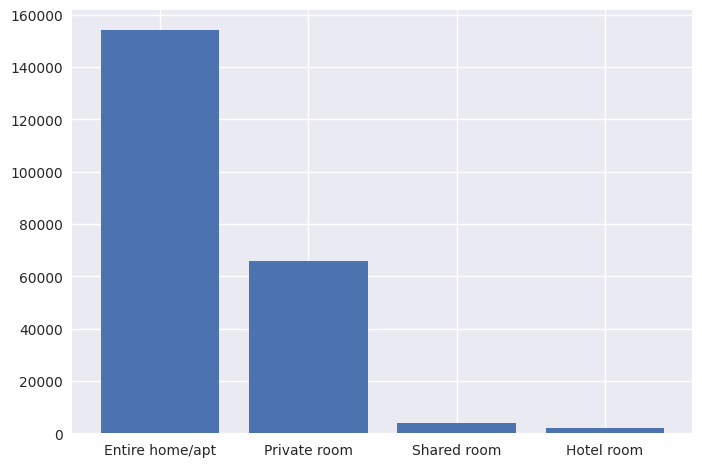

In [13]:
fig, ax = plt.subplots()
room_type = house_df["room_type"].value_counts()
ax.bar(room_type.index, room_type.values)

In [14]:
house_df[pd.isna(house_df.price)]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city


In [15]:
house_df[pd.isna(house_df["availability_365"])]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city


In [16]:
house_df[pd.isna(house_df["city"])]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city


In [17]:
len(house_df["city"].unique())

28

/tmp/ipykernel_18620/2465990809.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


[Text(0, 0, 'New York City'),
 Text(1, 0, 'Los Angeles'),
 Text(2, 0, 'Hawaii'),
 Text(3, 0, 'San Diego'),
 Text(4, 0, 'Broward County'),
 Text(5, 0, 'Austin'),
 Text(6, 0, 'Clark County'),
 Text(7, 0, 'Washington D.C.'),
 Text(8, 0, 'San Clara Country'),
 Text(9, 0, 'San Francisco'),
 Text(10, 0, 'Seattle'),
 Text(11, 0, 'Twin Cities MSA'),
 Text(12, 0, 'New Orleans'),
 Text(13, 0, 'Chicago'),
 Text(14, 0, 'Nashville'),
 Text(15, 0, 'Portland'),
 Text(16, 0, 'Denver'),
 Text(17, 0, 'Rhode Island'),
 Text(18, 0, 'Boston'),
 Text(19, 0, 'Oakland'),
 Text(20, 0, 'San Mateo County'),
 Text(21, 0, 'Jersey City'),
 Text(22, 0, 'Asheville'),
 Text(23, 0, 'Santa Cruz County'),
 Text(24, 0, 'Columbus'),
 Text(25, 0, 'Cambridge'),
 Text(26, 0, 'Salem'),
 Text(27, 0, 'Pacific Grove')]

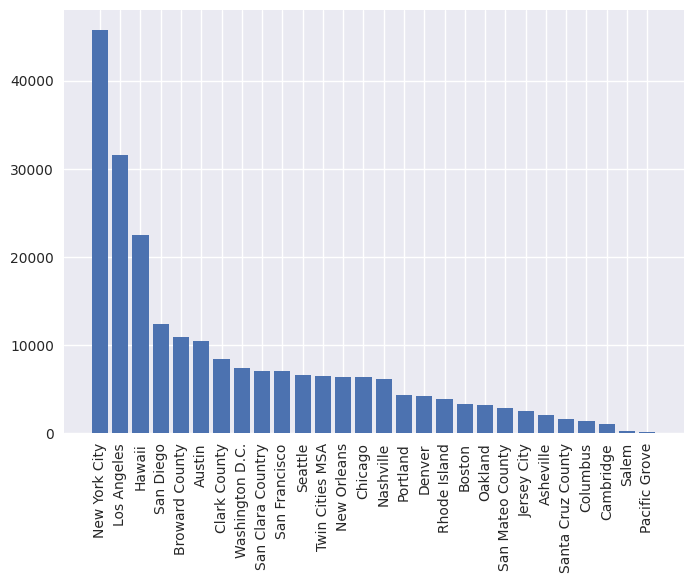

In [18]:
fig, ax = plt.subplots()
room_type = house_df["city"].value_counts()
ax.bar(room_type.index, room_type.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [19]:
house_df = house_df.query("minimum_nights < 10000")

In [20]:
house_df.query("price > 10000")

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
1845,42513939,Almost Heaven Too,303909632,Thomas,<NA>,28704,35.46876,-82.50776,Entire home/apt,24999,2,5,09/08/20,1.55,4,253,Asheville
1846,42513942,Almost Heaven,303909632,Thomas,<NA>,28704,35.46809,-82.50764,Entire home/apt,24999,2,4,29/06/20,0.62,4,258,Asheville
1950,43924301,Haw Creek Escape: Right on the doorstep of Dow...,96187307,Steve,<NA>,28805,35.59742,-82.50561,Entire home/apt,24999,2,0,<NA>,<NA>,26,236,Asheville
9432,36868625,Sapphire on Lake Austin,210733801,Above,<NA>,78733,30.33455,-97.84607,Entire home/apt,11373,99,0,<NA>,<NA>,44,151,Austin
55106,18635070,4 Bedrooms! New Listing! Pool! Ocean Views! Go...,680107,Kahea,Hawaii,North Kona,19.64033,-155.96396,Entire home/apt,24999,3,2,13/04/18,0.06,127,0,Hawaii
56120,20472161,Royal Kailua Estate,239633467,Christopher,Honolulu,Koolaupoko,21.40407,-157.73859,Entire home/apt,20000,30,0,<NA>,<NA>,1,337,Hawaii
56173,20475425,Thousand Waves,196672337,Jodie,Maui,Lahaina,20.93563,-156.69214,Entire home/apt,11000,7,0,<NA>,<NA>,3,349,Hawaii
56176,20475538,The Sullivan Estate JK7 SPA Retreat,186139965,Karin,Honolulu,North Shore Oahu,21.65072,-158.05930,Entire home/apt,24600,30,0,<NA>,<NA>,1,365,Hawaii
57668,22635984,Dancing Bamboo Cottage - Minutes from Hawaii V...,680107,Kahea,Hawaii,Puna,19.43983,-155.17562,Entire home/apt,24999,3,0,<NA>,<NA>,127,0,Hawaii
58512,24231447,Kailua Shores Estate,107293305,Elite Pacific,Honolulu,Koolaupoko,21.39893,-157.73526,Entire home/apt,10500,30,0,<NA>,<NA>,181,332,Hawaii


In [21]:
len(house_df.query("price > 10000"))

48

In [22]:
house_df.query("price > 2000 and price < 3000")

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
2258,367789,Completely Renovated Mid Century,1856695,John,<NA>,78703,30.30665,-97.77151,Entire home/apt,2150,4,1,17/03/14,0.01,1,0,Austin
2342,706950,Walk to Zilker - 4 bedroom 3.5 bath,3633458,Brent,<NA>,78703,30.28251,-97.77571,Entire home/apt,2250,5,0,<NA>,<NA>,1,0,Austin
2472,968064,"East Austin, 6BR near Downtown",2852262,Kate,<NA>,78702,30.25041,-97.72592,Entire home/apt,2200,3,2,12/03/14,0.02,3,365,Austin
2740,2345033,SXSW House only 10 mins to Downtown,11975520,Ivy,<NA>,78746,30.27678,-97.80504,Entire home/apt,2500,5,0,<NA>,<NA>,1,0,Austin
2817,2459312,SXSW Rental - House - Sleeps 12+,12574160,Nick,<NA>,78737,30.21682,-97.99589,Entire home/apt,2500,1,0,<NA>,<NA>,1,0,Austin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220753,16439413,Town House for Women\'s March,11292177,Lola,<NA>,"Spring Valley, Palisades, Wesley Heights, Foxh...",38.90769,-77.08058,Entire home/apt,2200,2,0,<NA>,<NA>,1,0,Washington D.C.
220762,16447429,Beautiful Chevy Chase Row Home,25964857,Taurus,<NA>,"Hawthorne, Barnaby Woods, Chevy Chase",38.95548,-77.07087,Entire home/apt,2500,1,0,<NA>,<NA>,1,179,Washington D.C.
220801,16480798,3 Bedroom Home in Capital Hill,108195453,Reid,<NA>,"Capitol Hill, Lincoln Park",38.88499,-76.99060,Entire home/apt,2500,3,0,<NA>,<NA>,1,0,Washington D.C.
220876,16567494,Contemporary 2-story 2 bedroom by Logan Circle,19537606,Borja,<NA>,"Shaw, Logan Circle",38.90861,-77.02831,Entire home/apt,2500,2,0,<NA>,<NA>,1,0,Washington D.C.


In [23]:
house_df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city'],
      dtype='object')

In [24]:
df = house_df.loc[:, ['latitude', 'longitude', 'room_type', 'price',  'minimum_nights', 
               'calculated_host_listings_count', 'availability_365'
               ]].copy()

In [25]:
df

,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,35.651460,-82.627920,Private room,60,1,1,0
1,35.597790,-82.555400,Entire home/apt,470,1,11,288
2,35.606700,-82.555630,Entire home/apt,75,30,2,298
3,35.578640,-82.595780,Entire home/apt,90,1,5,0
4,35.614420,-82.541270,Private room,125,30,1,0
...,...,...,...,...,...,...,...
226025,38.903880,-77.029730,Entire home/apt,104,1,2,99
226026,38.920820,-76.990980,Entire home/apt,151,2,1,300
226027,38.911170,-77.033540,Entire home/apt,240,2,1,173
226028,38.926630,-77.044360,Entire home/apt,60,21,5,362


In [26]:
def get_distance(x):
    lat1, lat2 = x.latitude, 0
    lon1, lon2 = x.longitude, 0
    R = 6371 #* 1e3
    phi1 = lat1 * math.pi/180
    phi2 = lat2 * math.pi/180
    
    delta_phi = (lat2 - lat1) * math.pi/180;
    delta_lambda = ( lon2 - lon1) * math.pi/180;

    a = math.sin(delta_phi/2) * math.sin(delta_phi/2) + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2) * math.sin(delta_lambda/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));

    d = R * c
    
    return d

df["distance"] = df.apply(get_distance, axis=1)

In [27]:
df

,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,distance
0,35.651460,-82.627920,Private room,60,1,1,0,9342.069677
1,35.597790,-82.555400,Entire home/apt,470,1,11,288,9335.082997
2,35.606700,-82.555630,Entire home/apt,75,30,2,298,9335.178879
3,35.578640,-82.595780,Entire home/apt,90,1,5,0,9338.562925
4,35.614420,-82.541270,Private room,125,30,1,0,9333.949659
...,...,...,...,...,...,...,...,...
226025,38.903880,-77.029730,Entire home/apt,104,1,2,99,8889.024618
226026,38.920820,-76.990980,Entire home/apt,151,2,1,300,8885.976666
226027,38.911170,-77.033540,Entire home/apt,240,2,1,173,8889.466929
226028,38.926630,-77.044360,Entire home/apt,60,21,5,362,8890.639369


In [28]:
df.drop(["latitude", "longitude", "room_type"], axis=1, inplace=True)

In [29]:
df

,price,minimum_nights,calculated_host_listings_count,availability_365,distance
0,60,1,1,0,9342.069677
1,470,1,11,288,9335.082997
2,75,30,2,298,9335.178879
3,90,1,5,0,9338.562925
4,125,30,1,0,9333.949659
...,...,...,...,...,...
226025,104,1,2,99,8889.024618
226026,151,2,1,300,8885.976666
226027,240,2,1,173,8889.466929
226028,60,21,5,362,8890.639369


In [30]:
df_trans = pd.DataFrame(preprocessing.scale(df, axis=0), columns=df.columns)

In [31]:
df_trans

,price,minimum_nights,calculated_host_listings_count,availability_365,distance
0,-0.280032,-0.361563,-0.307401,-1.136513,-0.783206
1,0.438820,-0.361563,-0.111587,0.917999,-0.786081
2,-0.253732,0.786901,-0.287819,0.989337,-0.786041
3,-0.227433,-0.361563,-0.229075,-1.136513,-0.784649
4,-0.166068,0.786901,-0.307401,-1.136513,-0.786547
...,...,...,...,...,...
226024,-0.202887,-0.361563,-0.287819,-0.430275,-0.969586
226025,-0.120482,-0.321961,-0.307401,1.003604,-0.970840
226026,0.035562,-0.321961,-0.307401,0.097621,-0.969404
226027,-0.280032,0.430481,-0.229075,1.445895,-0.968922


In [32]:
df_trans.describe()

,price,minimum_nights,calculated_host_listings_count,availability_365,distance
count,2.260290e+05,2.260290e+05,2.260290e+05,2.260290e+05,2.260290e+05
mean,3.017847e-18,-2.011898e-18,4.375879e-17,4.023797e-17,1.178972e-15
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.852298e-01,-3.615630e-01,-3.074007e-01,-1.136513e+00,-1.150695e+00
25%,-2.537325e-01,-3.615630e-01,-3.074007e-01,-1.136513e+00,-9.735716e-01
50%,-1.730807e-01,-3.219608e-01,-2.878193e-01,-1.377919e-01,-2.006693e-01
75%,-3.281684e-02,-1.239498e-01,-2.094938e-01,1.082075e+00,5.511567e-01
max,4.344548e+01,4.910158e+01,1.128477e+01,1.467296e+00,2.255573e+00


In [33]:
pd.DataFrame(preprocessing.StandardScaler().fit_transform(df), columns=df.columns)

,price,minimum_nights,calculated_host_listings_count,availability_365,distance
0,-0.280032,-0.361563,-0.307401,-1.136513,-0.783206
1,0.438820,-0.361563,-0.111587,0.917999,-0.786081
2,-0.253732,0.786901,-0.287819,0.989337,-0.786041
3,-0.227433,-0.361563,-0.229075,-1.136513,-0.784649
4,-0.166068,0.786901,-0.307401,-1.136513,-0.786547
...,...,...,...,...,...
226024,-0.202887,-0.361563,-0.287819,-0.430275,-0.969586
226025,-0.120482,-0.321961,-0.307401,1.003604,-0.970840
226026,0.035562,-0.321961,-0.307401,0.097621,-0.969404
226027,-0.280032,0.430481,-0.229075,1.445895,-0.968922


In [34]:
models = []
for nclust in range(2, 20):
    model = KMeans(n_clusters=nclust, init="k-means++", random_state=0, n_init="auto")
    model.fit(df_trans)
    models.append(model)

In [35]:
model.cluster_centers_

array([[-1.03489142e-01, -2.20049301e-01, -1.95807169e-01,
         7.30239401e-02, -8.21776495e-01],
       [ 1.41925041e-01, -1.55171557e-01,  3.66496165e+00,
         6.61763520e-01,  2.07970654e+00],
       [-1.06508700e-01, -3.07014925e-01, -2.22449579e-01,
        -7.01321392e-01,  4.96146349e-01],
       [ 1.40915902e-01,  1.36729767e+01, -2.26824477e-01,
         4.16588701e-01, -2.14475138e-01],
       [-2.86883896e-02, -3.02582944e-01, -1.82079550e-01,
         1.11943703e+00,  5.12146768e-01],
       [ 1.59359304e+01, -1.23024062e-01,  3.38886181e-01,
         2.72658162e-02,  1.79206767e-01],
       [-7.59773653e-02,  4.04235970e+00, -2.17511858e-01,
         2.53897662e-01, -5.50757468e-01],
       [-1.12255552e-01, -2.37572650e-01, -2.54542215e-01,
        -9.95427853e-01, -8.78178540e-01],
       [ 3.86627485e+00, -8.62366078e-02, -1.25367697e-01,
         1.77044145e-01,  1.76720970e-01],
       [-1.14706344e-01,  8.07658415e-01, -1.47161409e-01,
         1.16518219e+00

In [36]:
model.predict(df_trans)

array([ 7, 14, 16, ...,  0, 16,  7], dtype=int32)

In [37]:
sorted(house_df.price.unique())[-10:]

[12500, 12750, 14500, 15000, 15339, 18000, 20000, 21053, 24600, 24999]

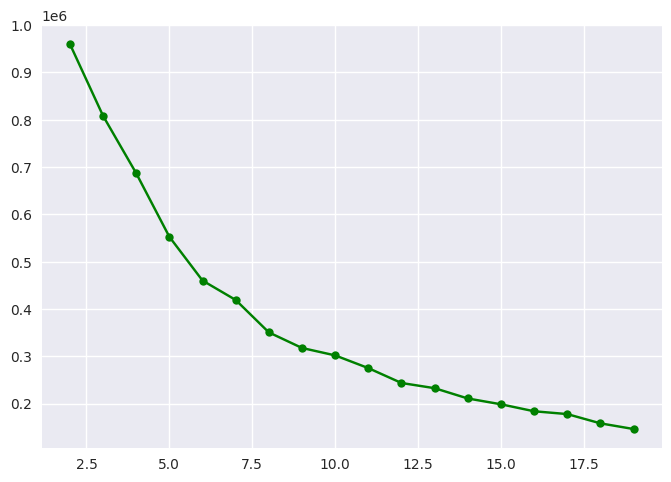

In [38]:
fig, ax = plt.subplots()
ax.plot(range(2, 20), [m.inertia_ for m in models], "g-", markersize=6, marker="o")

In [39]:
k = 5
model = KMeans(n_clusters=5, init="k-means++", random_state=0, n_init="auto")
model.fit(df_trans)

KMeans(n_clusters=5, n_init='auto', random_state=0)

In [40]:
house_df["clusters"] = model.predict(df_trans)

/tmp/ipykernel_18620/22132421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df["clusters"] = model.predict(df_trans)


In [41]:
house_df["distance"] = house_df.apply(get_distance, axis=1)

/tmp/ipykernel_18620/216906811.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df["distance"] = house_df.apply(get_distance, axis=1)


In [42]:
house_df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city,clusters,distance
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,<NA>,28804,35.651460,-82.627920,Private room,60,1,138,16/02/20,1.14,1,0,Asheville,3,9342.069677
1,80905,French Chic Loft,427027,Celeste,<NA>,28801,35.597790,-82.555400,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville,0,9335.082997
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,<NA>,28801,35.606700,-82.555630,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville,0,9335.178879
3,155305,Cottage! BonPaul + Sharky\'s Hostel,746673,BonPaul,<NA>,28806,35.578640,-82.595780,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville,3,9338.562925
4,160594,Historic Grove Park,769252,Elizabeth,<NA>,28801,35.614420,-82.541270,Private room,125,30,58,19/10/15,0.52,1,0,Asheville,3,9333.949659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226025,45506143,"DC Hidden In Plain \""Site\""",25973146,Marci,<NA>,"Downtown, Chinatown, Penn Quarters, Mount Vern...",38.903880,-77.029730,Entire home/apt,104,1,0,<NA>,<NA>,2,99,Washington D.C.,3,8889.024618
226026,45511428,DC 3 BR w/ screen porch 3 blck to metro w/ par...,231133074,Thomas,<NA>,"Brookland, Brentwood, Langdon",38.920820,-76.990980,Entire home/apt,151,2,0,<NA>,<NA>,1,300,Washington D.C.,0,8885.976666
226027,45514685,Charming Penthouse Apt w/ Rooftop Terrace in L...,33758935,Bassem,<NA>,"Shaw, Logan Circle",38.911170,-77.033540,Entire home/apt,240,2,0,<NA>,<NA>,1,173,Washington D.C.,0,8889.466929
226028,45516412,Adams Morgan/Nat\'l Zoo 1 BR Apt 32,23193071,Michael,<NA>,"Kalorama Heights, Adams Morgan, Lanier Heights",38.926630,-77.044360,Entire home/apt,60,21,0,<NA>,<NA>,5,362,Washington D.C.,0,8890.639369


In [43]:
price_df = house_df[["clusters", "price"]].groupby(by=["clusters"]).apply(lambda x: x).drop(columns=["clusters"])
price_df

price
clusters              
0        1         470
         2          75
         5         134
         8          71
         9          50
...                ...
4        220129   5995
         220189  10000
         220957   5000
         221111   5000
         224151   9999

[226029 rows x 1 columns]

In [44]:
prices = []
for i in range(k):
    prices.append(house_df.loc[house_df["clusters"] == i, "price"])

In [45]:
prices[0]

1         470
2          75
5         134
8          71
9          50
         ... 
226023     50
226024     32
226026    151
226027    240
226028     60
Name: price, Length: 48800, dtype: int64

In [46]:
prices[1]

11316      96
11342     103
11343     125
11344     103
11345     129
         ... 
225988     96
225990     93
225996     96
225998    148
226020    148
Name: price, Length: 7051, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb972ac6af0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb972d06070>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb972ac6850>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb972d065b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb972d06850>,
 'means': []}

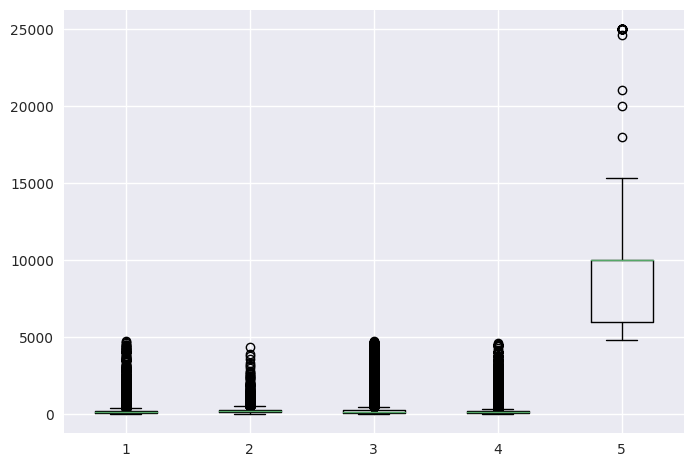

In [47]:
fig, ax = plt.subplots()
ax.boxplot(prices)

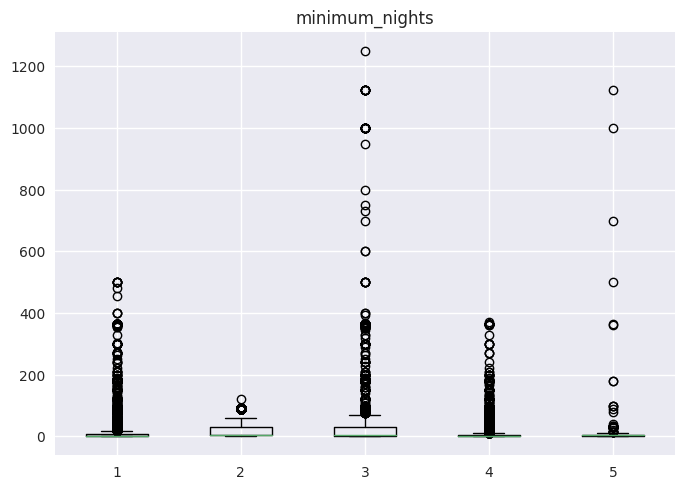

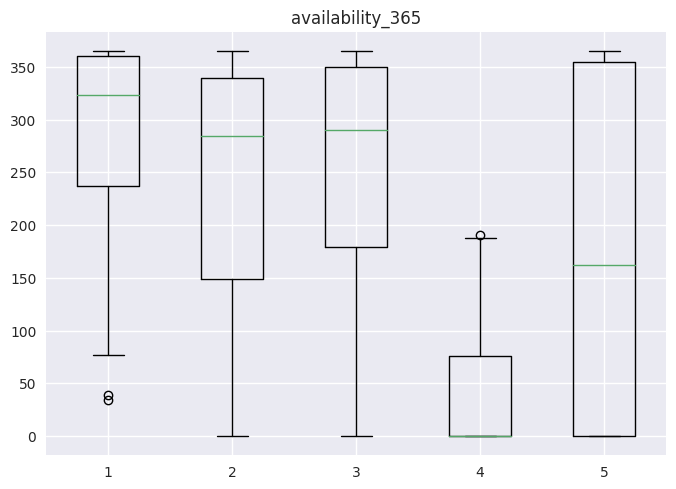

In [48]:
for col in [ 'minimum_nights', 'availability_365']:
    data = []
    for i in range(k):
        data.append(house_df.loc[house_df["clusters"] == i, col])
    fig, ax = plt.subplots()
    ax.boxplot(data)
    ax.set(title=col)

In [49]:
house_df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city', 'clusters', 'distance'],
      dtype='object')

In [50]:
df["minimum_nights"].max()

1250

[Text(0.5, 0, 'price'), Text(0, 0.5, 'minimum_nights')]

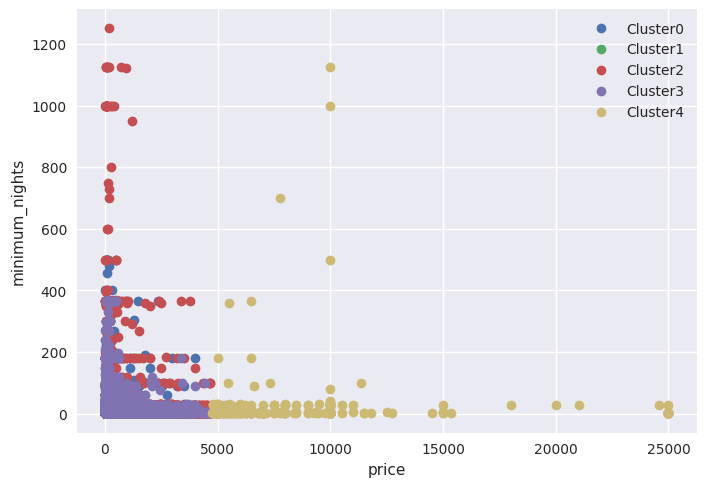

In [51]:
fig, ax = plt.subplots()
_df = house_df[["price",  'minimum_nights', "clusters"]]
for i in range(k):
    data = _df.query(f"clusters == {i}")
    ax.plot(data["price"],  data["minimum_nights"], "o", label=f"Cluster{i}")

ax.legend()
ax.set(xlabel="price", ylabel="minimum_nights")

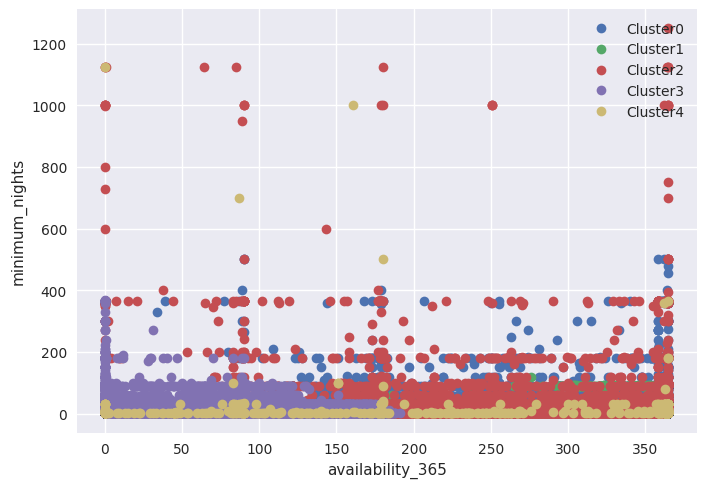

In [52]:
fig, ax = plt.subplots()
_df = house_df[["minimum_nights",  'availability_365', "clusters"]]
for i in range(k):
    data = _df.query(f"clusters == {i}")
    ax.plot(  data["availability_365"], data["minimum_nights"], "o", label=f"Cluster{i}")

ax.set(ylabel="minimum_nights", xlabel="availability_365")
ax.legend(loc="upper right")


In [53]:
len(house_df['city'].unique())


28

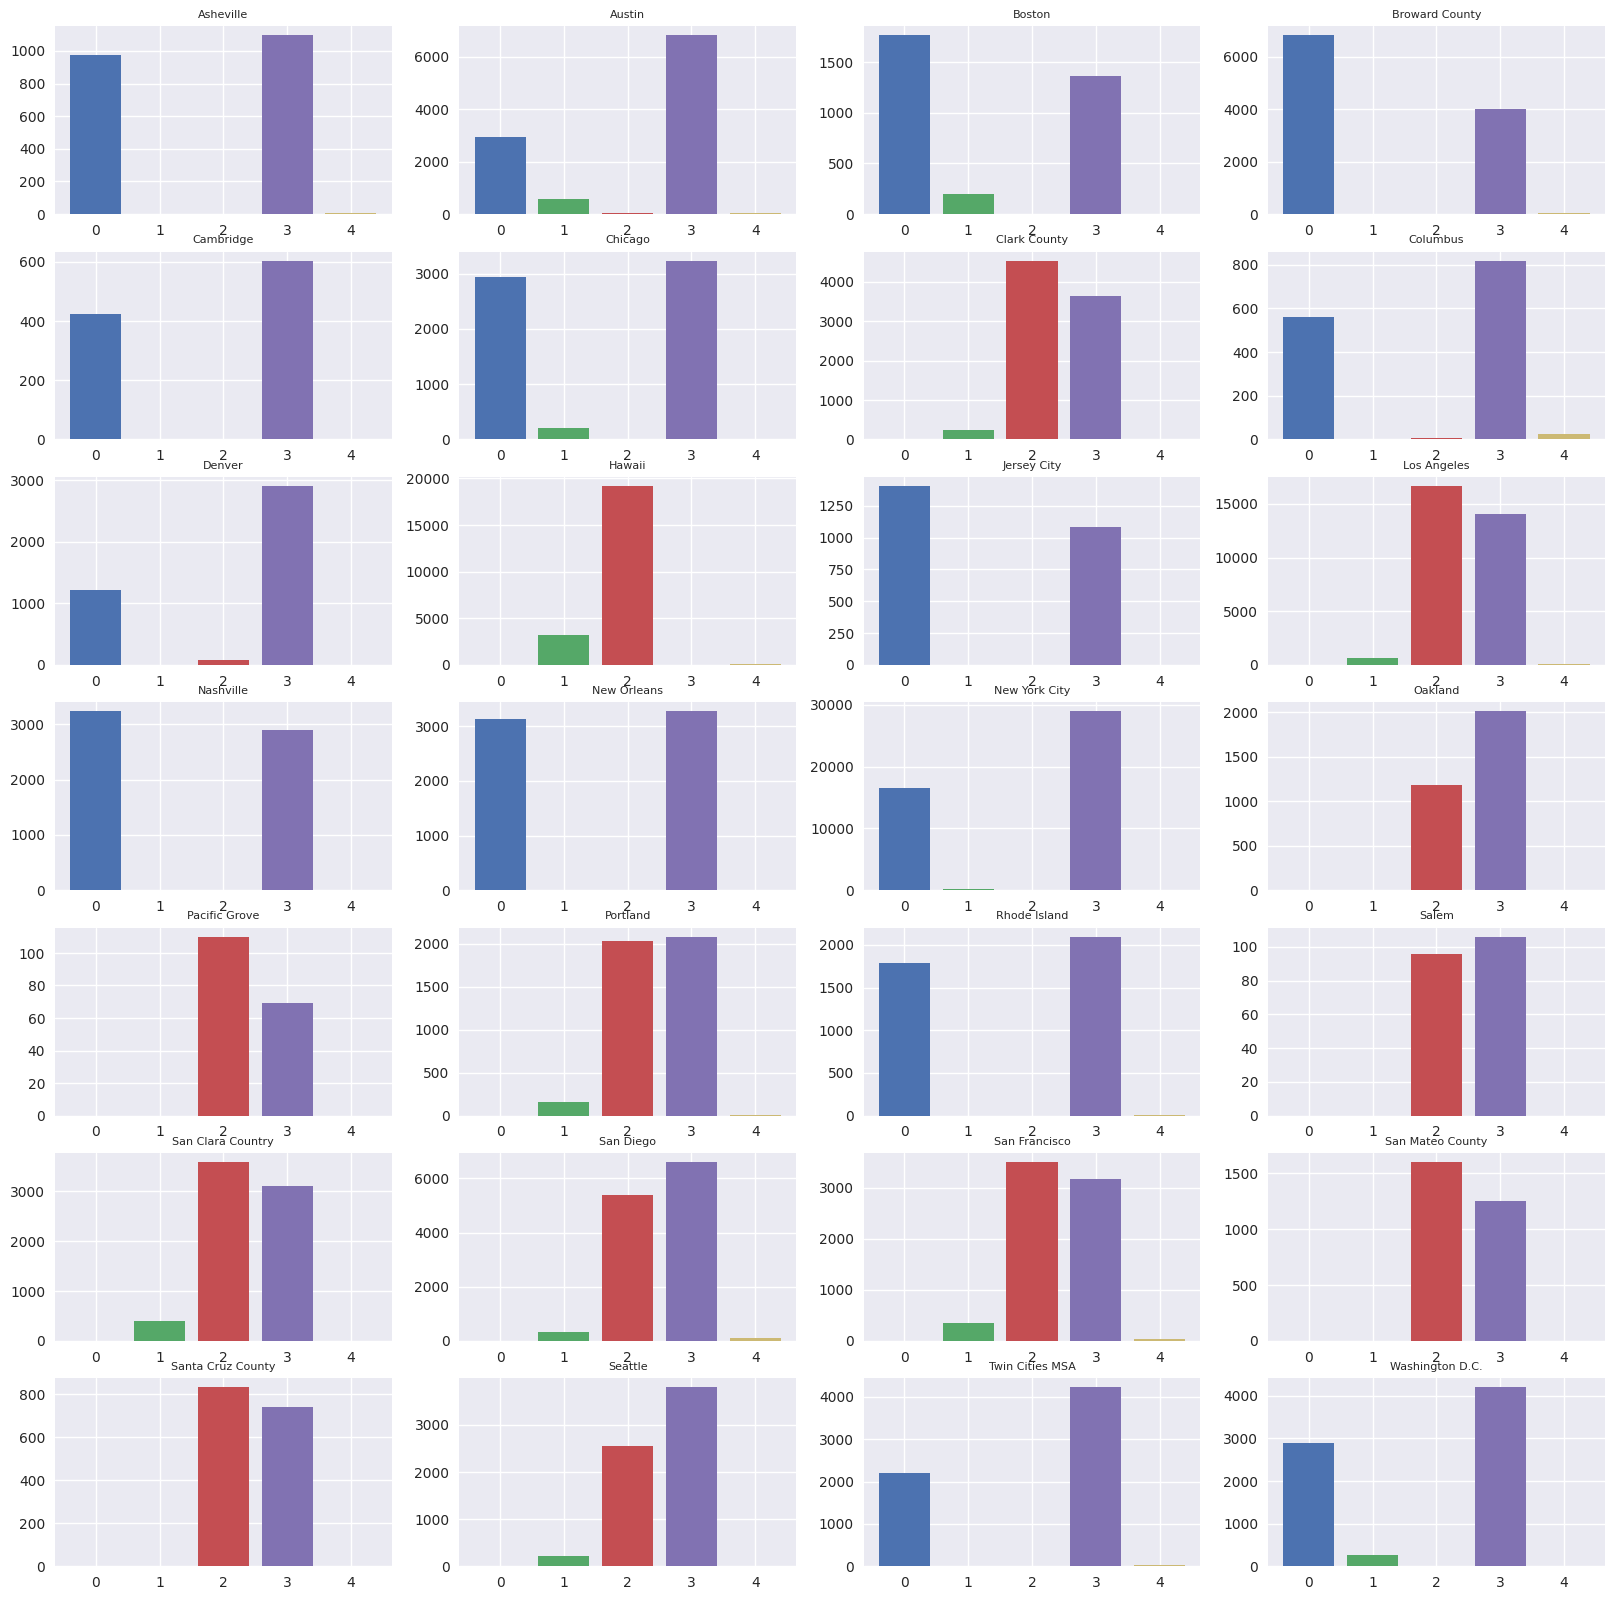

In [58]:
nplots = len(house_df["city"].unique())

ncol = 4
nrow = nplots // ncol
city_clusters = dict([(i, []) for i in range(k)])
fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20, 20))
for i, city in enumerate(house_df['city'].unique(), 0):
    ax = axes[i // ncol, i % ncol ]
    _df = house_df[house_df["city"] == city]
    counts = _df["clusters"].value_counts()
    for j in range(k):
        if not counts.get(j):
            counts[j] = 0
    counts = counts.sort_index()
    city_clusters[np.argmax(counts)].append(city)
    
    ax.bar(counts.index, counts.values, color=[f'C{j}' for j in range(k)])
    ax.set_title(city, fontsize=8)


In [59]:
city_clusters

{0: ['Boston', 'Broward County', 'Jersey City', 'Nashville'],
 1: [],
 2: ['Clark County',
  'Hawaii',
  'Los Angeles',
  'Pacific Grove',
  'San Clara Country',
  'San Francisco',
  'San Mateo County',
  'Santa Cruz County'],
 3: ['Asheville',
  'Austin',
  'Cambridge',
  'Chicago',
  'Columbus',
  'Denver',
  'New Orleans',
  'New York City',
  'Oakland',
  'Portland',
  'Rhode Island',
  'Salem',
  'San Diego',
  'Seattle',
  'Twin Cities MSA',
  'Washington D.C.'],
 4: []}